In [1]:
import time
import sys
import numpy as np
import pinocchio as pin
import matplotlib.pyplot as plt
from matplotlib import cm, animation
sys.path.insert(0, '..')
from src.embedding import Embedding, Collision, JointLimit
from src.forward_kinematics import ForwardKinematic
from src.dynamical_system import DynamicalSystem

In [2]:
# add an obstacle to the workspace
x = np.array([[-0.5], [1.4], [0.]])[np.newaxis, :]
# place an attractor in the configuration space
config_attractor = np.array([1., 0.15])

fk = ForwardKinematic(
    urdf_file='../description/2_joints_arm.urdf',
    gmm_configuration_file="../config/gmm_unit.json"
)

# define joint angle limits
joint_limits = [
    {'lower': -np.pi/2, 'upper': np.pi/2},
    {'lower': -np.pi/2, 'upper': np.pi/2}
]

e = Embedding(embeddings=[Collision(x=x, fk=fk)])

# define proportional and dissipation gains for the DS
k, d = 1, 1.5
ds = DynamicalSystem(stiffness=k*np.eye(2), dissipation=d*np.eye(2), attractor=config_attractor, embedding=e, dt=0.01)

# Embedded representation of the configuration space

In [3]:
# creating a discrete representation of the configuration space
q1 = np.linspace(joint_limits[0]['lower'], joint_limits[0]['upper'], 100)
q2 = np.linspace(joint_limits[1]['lower'], joint_limits[1]['upper'], 100)
gridX, gridY = np.meshgrid(q1, q2)
grid = np.column_stack((gridX.ravel(), gridY.ravel()))

In [4]:
# computing the collision probability for each configuration
a = np.zeros((grid.shape[0], 3))
for i, q in enumerate(grid):
    p = ds.embedding.value(q=q, dq=np.zeros_like(q), derivation_order=0).sum()
    a[i] = np.array([q[0], q[1], p])

# Computing the trajectories

In [5]:
q = np.array([-0.5, -1.2])
dq = np.zeros_like(q)
ds.x_logger = []
for i in range(0,1000):
    q, dq = ds(q, dq, kappa=0.15)

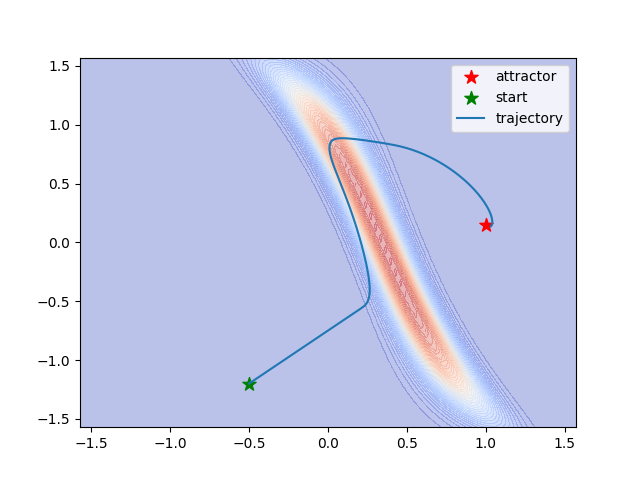

In [6]:
x1 = np.unique(a[:, 0])
x2 = np.unique(a[:, 1])
z = a[:, 2].reshape((x1.shape[0], x2.shape[0]))

ps= np.stack(ds.x_logger)
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot()
ax.contourf(x1, x2, z, cmap=cm.coolwarm, alpha=0.35, levels=50)
ax.scatter(config_attractor[0], config_attractor[1], label='attractor', marker='*', c='r', s=100)
ax.scatter(ps[0][0], ps[0][1], label='start', marker='*', c='g', s=100)
ax.plot(ps[:, 0], ps[:, 1], label="trajectory")
ax.set_xlim([x1.min(), x1.max()])
ax.set_ylim([x2.min(), x2.max()])
plt.legend()
plt.show()

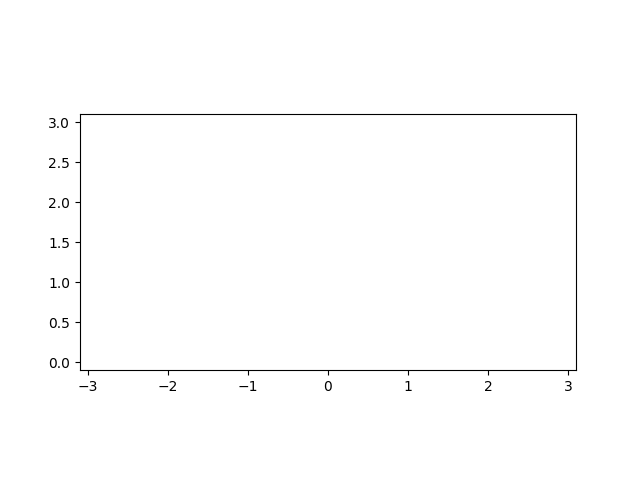

In [7]:
def animate_robot(i, configurations, fk: ForwardKinematic, ax):
    ax.clear()
    ax.set_xlim([-3.1, 3.1])
    ax.set_ylim([-0.1, 3.1])
    # ax.plot(config_attractor[0], config_attractor[1], 'y*', markersize=20, markeredgecolor='black', markeredgewidth=1)
    # for obs in [obstacle]:
    obstacle = e.x
    ax.scatter(obstacle[:, 0], obstacle[:, 1], c='r', s=12)
    q = configurations[i]
    pin.forwardKinematics(fk.model, fk.data, q)
    pin.updateFramePlacements(fk.model, fk.data)
    _ = fk(q=q, dq=np.zeros_like(q), derivation_order=0)
    mus = fk.mus
    ax.scatter(mus[:, 0], mus[:, 1], c='m', s=25)
    # Plot the target point with a border
    ee = fk.data.oMf[fk.model.getFrameId('ee')].translation
    link2 = fk.data.oMf[fk.model.getFrameId('link2')].translation
    base = fk.data.oMf[fk.model.getFrameId('link1')].translation
    # Plot the base of the robotic arm with a border
    alpha = 1.0 if i == 0 else 0.5  # Adjust opacity based on configuration index
    ax.plot(base[0], base[1], 'bo', markersize=20, alpha=alpha, markeredgecolor='black', markeredgewidth=3, zorder=10)
    ax.plot([base[0], link2[0]], [base[1], link2[1]], 'k-', linewidth=8, alpha=alpha)  # Link
    ax.plot(link2[0], link2[1], 'ko', markersize=10, markeredgecolor='black', markeredgewidth=1, zorder=10)  # Joint

    # Plot the end effector of the robotic arm with a border
    ax.plot([link2[0], ee[0]], [link2[1], ee[1]], 'k-', linewidth=8, alpha=alpha)  # Link
    ax.plot(ee[0], ee[1], 'go', markersize=10, markeredgecolor='black', markeredgewidth=3, zorder=10)


fig, ax = plt.subplots()
# ax.scatter(x[0], x[1], c='r', s=12)
ax.set_aspect('equal', 'box')
ax.set_xlim([-3.1, 3.1])
ax.set_ylim([-0.1, 3.1])
dt = 0.004
step = int(np.round(0.016/dt))
ani = animation.FuncAnimation(fig, animate_robot, frames=np.arange(0, ps.shape[0], step, dtype=np.intc),fargs=(ps, fk, ax), interval=step*dt*1000, repeat=False)